In [10]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import joblib
# Load your data
df = pd.read_csv('stock_price_pivot.csv', parse_dates=['Date'], index_col='Date')


In [11]:
import pymysql
import datetime

In [12]:
df = df.asfreq('B')  # 'B' stands for business day frequency

# Check and forward-fill any missing values
df.fillna(method='ffill', inplace=True)

In [13]:
df

,close_AAPL,close_AMZN,close_GOOGL,close_MSFT
Date,,,,
2023-06-12,183.789993,126.570000,123.639999,331.850006
2023-06-13,183.309998,126.660004,123.830002,334.290009
2023-06-14,183.949997,126.419998,123.669998,337.339996
2023-06-15,186.009995,127.110001,125.089996,348.100006
2023-06-16,184.919998,125.489998,123.529999,342.329987
...,...,...,...,...
2024-06-03,194.029999,178.339996,173.169998,413.519989
2024-06-04,194.350006,179.339996,173.789993,416.070007
2024-06-05,195.869995,181.279999,175.410004,424.010010


In [14]:
df.isnull().values.any()

False

In [15]:
#ADF TEST

#ADF TEST IS A CHECK FOR STATIONARITY OF A DATAFRAME

res = sm.tsa.adfuller(df['close_AMZN'])
print('p-value:{}'.format(res[1]))


p-value:0.8774311371539011


In [16]:
res = sm.tsa.adfuller(df['close_AMZN'].diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

p-value:2.673751444536066e-26


C:\Users\Tartila\anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


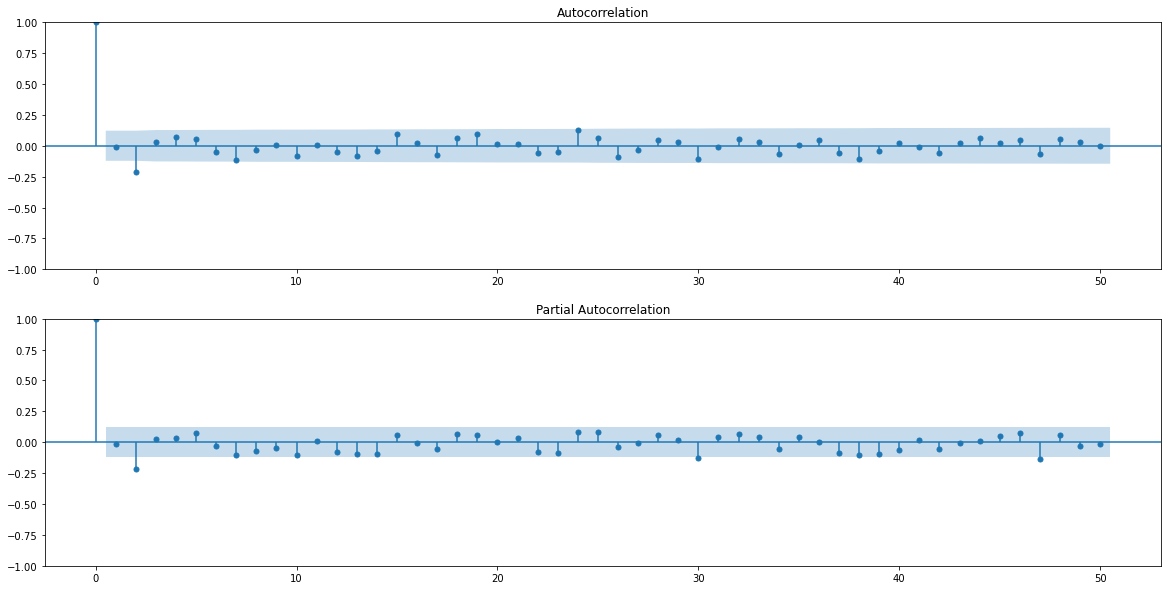

In [17]:
#ACF-PACF

fig, ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(df['close_AMZN'].diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['close_AMZN'].diff().dropna(), lags=50, ax=ax[1])
plt.show()


#PLOT INDICATES NO LAG SPIKES BETWEEN ACF AND PACF, indicating the differencing is enough without the needs of AR or MA

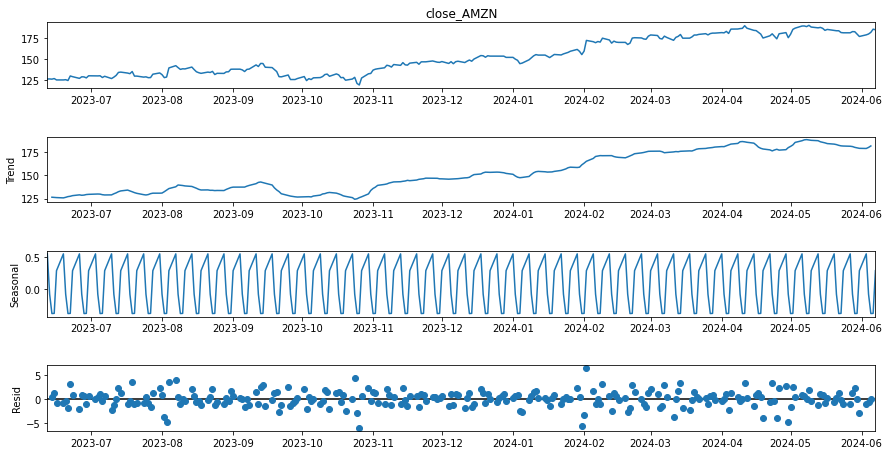

In [18]:
import statsmodels.api as sm

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df['close_AMZN'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()


In [19]:
import warnings
warnings.filterwarnings("ignore")
model = SARIMAX(df['close_AMZN'],order=(2,1,2), seasonal_order=(1, 1, 1, 5),exog=df[['close_MSFT','close_AAPL','close_GOOGL']])

In [20]:
df[['close_MSFT','close_AAPL','close_GOOGL']]

,close_MSFT,close_AAPL,close_GOOGL
Date,,,
2023-06-12,331.850006,183.789993,123.639999
2023-06-13,334.290009,183.309998,123.830002
2023-06-14,337.339996,183.949997,123.669998
2023-06-15,348.100006,186.009995,125.089996
2023-06-16,342.329987,184.919998,123.529999
...,...,...,...
2024-06-03,413.519989,194.029999,173.169998
2024-06-04,416.070007,194.350006,173.789993
2024-06-05,424.010010,195.869995,175.410004


In [21]:
res = model.fit(disp=False)

In [22]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          close_AMZN   No. Observations:                  260
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 5)   Log Likelihood                -524.173
Date:                             Fri, 14 Jun 2024   AIC                           1068.346
Time:                                     14:19:06   BIC                           1103.719
Sample:                                 06-12-2023   HQIC                          1082.576
                                      - 06-07-2024                                         
Covariance Type:                               opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
close_MSFT      0.2390      0.025      9.685      0.000       0.191       0.287
close_AAPL     -0.0236      0.046     -0.511      0.609      -0.114       0.067
close_GOOGL     0.3516      0.039      9.004      0.000       0.275       0.428
ar.L1           0.6864      1.248      0.550      0.582      -1.760       3.132
ar.L2          -0.5983      1.202     -0.498      0.619      -2.953       1.757
ma.L1          -0.6900      1.219     -0.566      0.571      -3.079       1.699
ma.L2           0.6307      1.174      0.537      0.591      -1.670       2.931
ar.S.L5         0.0955      0.085      1.119      0.263      -0.072       0.263
ma.S.L5        -0.9800      0.076    -12.894      0.000      -1.129      -0.831
sigma2          3.4136      0.320     10.660      0.000       2.786       4.041
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               275.85
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             1.15
Prob(H) (two-sided):                  0.36   Kurtosis:                         7.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# Check the length of the DataFrame
total_length = len(df)
print(f"Total length of DataFrame: {total_length}")

# # Display the first and last few indices to understand the range
# print("First few indices:", df.index[:5])
# print("Last few indices:", df.index[-5:])

# Determine a valid range for forecasting
# Ensure that the range is within the bounds of the DataFrame
valid_start = total_length - 5  # Example: Start 66 periods before the end
valid_end = total_length - 1     # Example: End at the last index




# Check the length of the exog DataFrame for the valid forecast period
exog_forecast = df[['close_MSFT', 'close_AAPL', 'close_GOOGL']].iloc[valid_start:valid_end+1]


Total length of DataFrame: 260


In [24]:
# Out-of-sample forecast using forecast
forecast_steps = 5
forecast_values =  res.forecast(steps=forecast_steps, exog=exog_forecast)

df_forecast = pd.DataFrame(forecast_values)

In [25]:
df_forecast

,predicted_mean
2024-06-10,181.988579
2024-06-11,182.431342
2024-06-12,184.644014
2024-06-13,185.731362
2024-06-14,185.156869


In [26]:
df = pd.concat([df,df_forecast],axis=1)

In [27]:
df

,close_AAPL,close_AMZN,close_GOOGL,close_MSFT,predicted_mean
2023-06-12,183.789993,126.570000,123.639999,331.850006,NaN
2023-06-13,183.309998,126.660004,123.830002,334.290009,NaN
2023-06-14,183.949997,126.419998,123.669998,337.339996,NaN
2023-06-15,186.009995,127.110001,125.089996,348.100006,NaN
2023-06-16,184.919998,125.489998,123.529999,342.329987,NaN
...,...,...,...,...,...
2024-06-10,NaN,NaN,NaN,NaN,181.988579
2024-06-11,NaN,NaN,NaN,NaN,182.431342
2024-06-12,NaN,NaN,NaN,NaN,184.644014
2024-06-13,NaN,NaN,NaN,NaN,185.731362


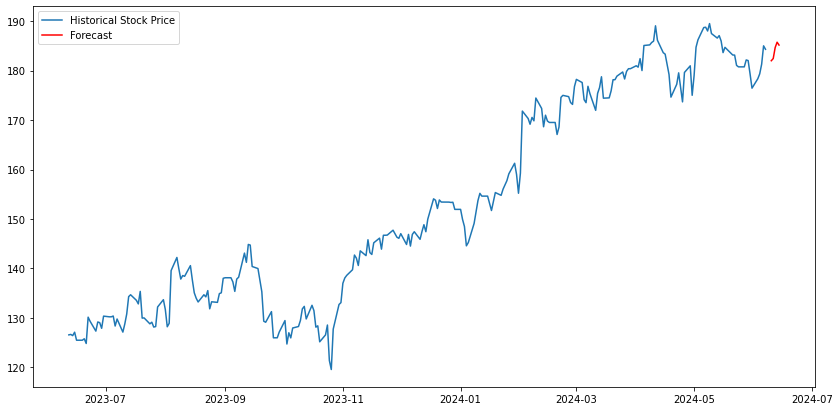

In [28]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(df['close_AMZN'], label='Historical Stock Price')
plt.plot(df['predicted_mean'], label='Forecast', color='red')
plt.legend()
plt.show()

In [19]:
joblib.dump(res, 'sarimax_model_AMZN.pkl')
print("Model saved successfully")

Model saved successfully


In [21]:
# MySQL database details
host = ''
database = ''
user = ''
password = ''
port =   # Custom port for Aiven MySQL

In [25]:
inserted_date = datetime.datetime.now()

In [28]:
try:
    connection = pymysql.connect(
        host=host,
        user=user,
        password=password,
        database=database,
        port=port
    )

    cursor = connection.cursor()

    # Create table if it doesn't exist
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS finnhub_stock_data_daily (
        symbol VARCHAR(10),
        record_date DATE,
        daily_avg_open FLOAT,
        daily_avg_high FLOAT,
        daily_avg_low FLOAT,
        daily_avg_close FLOAT,
        sarimax_prediction FLOAT,
        transformed_date DATETIME,
        PRIMARY KEY (symbol, record_date)
    )
    """)

    # Insert SARIMAX predictions
    for record_date, row in df_forecast.iterrows():
        cursor.execute("""
            INSERT INTO finnhub_stock_data_daily (symbol, record_date, sarimax_prediction, transformed_date)
            VALUES (%s, %s, %s, %s)
            ON DUPLICATE KEY UPDATE
                sarimax_prediction = VALUES(sarimax_prediction),
                transformed_date = VALUES(transformed_date)
        """, ('MSFT', record_date.date(), row['predicted_mean'], inserted_date))

    connection.commit()
    print("SARIMAX predictions inserted successfully")
            
except pymysql.MySQLError as e:
    print(f"Error: {e}")
finally:
    if connection:
        cursor.close()
        connection.close()
        print("MySQL connection is closed")

SARIMAX predictions inserted successfully
MySQL connection is closed


C:\Users\Tartila\anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


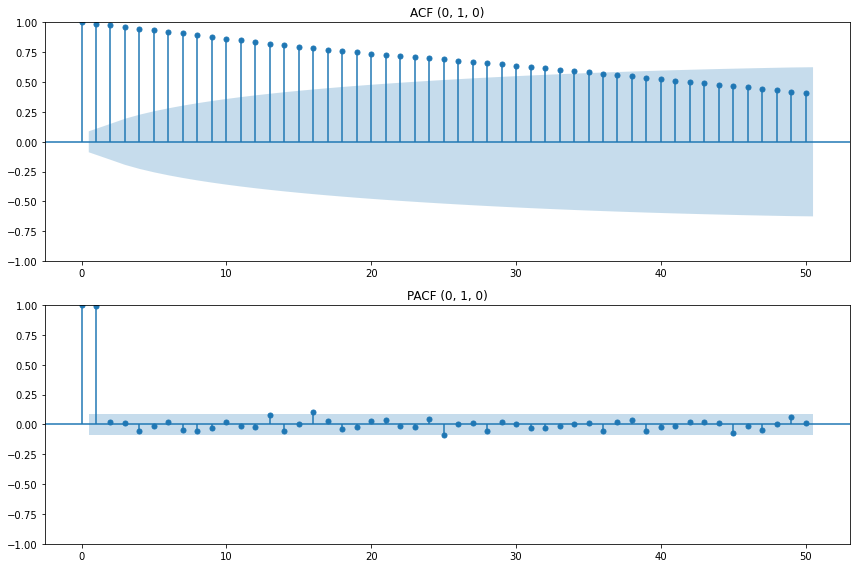

C:\Users\Tartila\anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


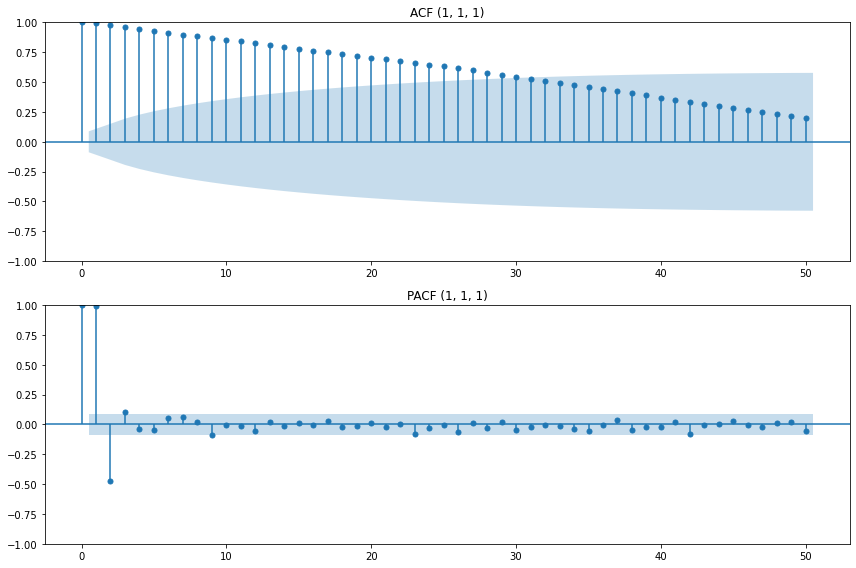

C:\Users\Tartila\anaconda3\envs\tfdeeplearning\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


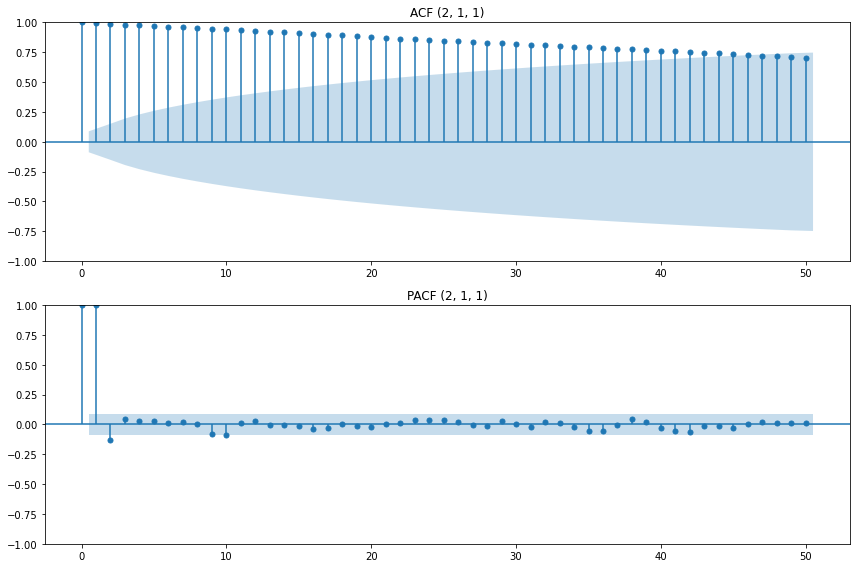

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess

# Function to generate synthetic data for a given ARMA process
def generate_data(ar, ma, d=1, n_samples=500):
    # Create an ARMA process
    arma_process = ArmaProcess(ar, ma)
    # Generate the synthetic data
    synthetic_data = arma_process.generate_sample(nsample=n_samples)
    # Apply differencing if d > 0
    if d > 0:
        synthetic_data = np.cumsum(synthetic_data)
    return synthetic_data

# Plot ACF and PACF
def plot_acf_pacf(data, title_suffix):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    sm.graphics.tsa.plot_acf(data, lags=50, ax=axes[0])
    sm.graphics.tsa.plot_pacf(data, lags=50, ax=axes[1])
    axes[0].set_title(f'ACF {title_suffix}')
    axes[1].set_title(f'PACF {title_suffix}')
    plt.tight_layout()
    plt.show()

# SARIMAX (0, 1, 0) -> ARIMA(0, 1, 0)
ar_010 = np.array([1])
ma_010 = np.array([1])
data_010 = generate_data(ar_010, ma_010)
plot_acf_pacf(data_010, '(0, 1, 0)')

# SARIMAX (1, 1, 1) -> ARIMA(1, 1, 1)
ar_111 = np.array([1, -0.5])  # AR coefficients
ma_111 = np.array([1, 0.5])  # MA coefficients
data_111 = generate_data(ar_111, ma_111)
plot_acf_pacf(data_111, '(1, 1, 1)')

# SARIMAX (2, 1, 1) -> ARIMA(2, 1, 1)
ar_211 = np.array([1, -0.5, 0.25])  # AR coefficients
ma_211 = np.array([1, 0.5])  # MA coefficients
data_211 = generate_data(ar_211, ma_211)
plot_acf_pacf(data_211, '(2, 1, 1)')
